In [1]:
import tensorflow as tf 
import numpy as np 
import gym
from tensorflow.keras.models import load_model

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [2]:
env= gym.make("LunarLander-v2")
low = env.observation_space.low
high = env.observation_space.high

In [3]:
class DDDQN(tf.keras.Model):
    def __init__(self):
      super(DDDQN, self).__init__()
      self.d1 = tf.keras.layers.Dense(128, activation='relu')
      self.d2 = tf.keras.layers.Dense(128, activation='relu')
      self.v = tf.keras.layers.Dense(1, activation=None)
      self.a = tf.keras.layers.Dense(env.action_space.n, activation=None)

    def call(self, input_data):
      x = self.d1(input_data)
      x = self.d2(x)
      v = self.v(x)
      a = self.a(x)
      Q = v +(a -tf.math.reduce_mean(a, axis=1, keepdims=True))
      return Q

    def advantage(self, state):
      x = self.d1(state)
      x = self.d2(x)
      a = self.a(x)
      return a

In [4]:
class exp_replay():
    def __init__(self, buffer_size= 1000000):
        self.buffer_size = buffer_size
        self.state_mem = np.zeros((self.buffer_size, *(env.observation_space.shape)), dtype=np.float32)
        self.action_mem = np.zeros((self.buffer_size), dtype=np.int32)
        self.reward_mem = np.zeros((self.buffer_size), dtype=np.float32)
        self.next_state_mem = np.zeros((self.buffer_size, *(env.observation_space.shape)), dtype=np.float32)
        self.done_mem = np.zeros((self.buffer_size), dtype=np.bool)
        self.pointer = 0

    def add_exp(self, state, action, reward, next_state, done):
        idx  = self.pointer % self.buffer_size 
        self.state_mem[idx] = state
        self.action_mem[idx] = action
        self.reward_mem[idx] = reward
        self.next_state_mem[idx] = next_state
        self.done_mem[idx] = 1 - int(done)
        self.pointer += 1

    def sample_exp(self, batch_size= 64):
        max_mem = min(self.pointer, self.buffer_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_mem[batch]
        actions = self.action_mem[batch]
        rewards = self.reward_mem[batch]
        next_states = self.next_state_mem[batch]
        dones = self.done_mem[batch]
        return states, actions, rewards, next_states, dones

In [5]:
class agent():
    def __init__(self, gamma=0.99, replace=100, lr=0.001):
        self.gamma = gamma
        self.epsilon = 1.0
        self.min_epsilon = 0.01
        self.epsilon_decay = 1e-3
        self.replace = replace
        self.trainstep = 0
        self.memory = exp_replay()
        self.batch_size = 64
        self.q_net = DDDQN()
        self.target_net = DDDQN()
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.q_net.compile(loss='mse', optimizer=opt)
        self.target_net.compile(loss='mse', optimizer=opt)


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice([i for i in range(env.action_space.n)])
        else:
            actions = self.q_net.advantage(np.array([state]))
            action = np.argmax(actions)
            return action


      
    def update_mem(self, state, action, reward, next_state, done):
        self.memory.add_exp(state, action, reward, next_state, done)


    def update_target(self):
        self.target_net.set_weights(self.q_net.get_weights())     

    def update_epsilon(self):
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.min_epsilon else self.min_epsilon
        return self.epsilon

          
    def train(self):
        if self.memory.pointer < self.batch_size:
            return 

        if self.trainstep % self.replace == 0:
            self.update_target()
        states, actions, rewards, next_states, dones = self.memory.sample_exp(self.batch_size)
        target = self.q_net.predict(states)
        next_state_val = self.target_net.predict(next_states)
        max_action = np.argmax(self.q_net.predict(next_states), axis=1)
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q_target = np.copy(target)
        q_target[batch_index, actions] = rewards + self.gamma * next_state_val[batch_index, max_action]*dones
        self.q_net.train_on_batch(states, q_target)
        self.update_epsilon()
        self.trainstep += 1

    def save_model(self):
        self.q_net.save_weights('dddqn-q_model_weights', save_format='tf')
        self.target_net.save_weights('target_net_model_weights', save_format='tf')

    def load_model(self):
        self.q_net.load_weights('q_model_weights')
        self.target_net.load_weights('target_net_model_weights')

In [11]:
import matplotlib.pyplot as plt
from collections import deque

import timeit
start = timeit.default_timer()    

aver_reward = []
aver = deque(maxlen=100)
rewards = []

agentoo7 = agent()
steps = 1000 
for s in range(steps):
    done = False
    state = env.reset()
    total_reward = 0
    while not done:
        #env.render()
        action = agentoo7.act(state)
        next_state, reward, done, _ = env.step(action)
        agentoo7.update_mem(state, action, reward, next_state, done)
        agentoo7.train()
        state = next_state
        total_reward += reward

        #if done:
          #print("total reward after {} episode is {} and epsilon is {}".format(s, total_reward, agentoo7.epsilon))
    
    aver.append(total_reward)     
    
    current_average_reward = np.mean(aver)
    aver_reward.append(current_average_reward)
    
    rewards.append(total_reward)

    print("Episode " +  str(s) + " total rewards = " + str(total_reward) + " average rewards = " + str(current_average_reward))
    


stop = timeit.default_timer()
duration_in_minutes = (stop - start) #/ 60
print('Execution Time (in sec): ' + str(duration_in_minutes)) 

agentoo7.save_model()   

Episode 0 total rewards = -67.52694374983639 average rewards = -67.52694374983639
Episode 1 total rewards = -137.89311153183093 average rewards = -102.71002764083366
Episode 2 total rewards = -131.96671835194826 average rewards = -112.46225787787186
Episode 3 total rewards = -342.19682306798313 average rewards = -169.89589917539968
Episode 4 total rewards = 13.444623361234491 average rewards = -133.22779466807285
Episode 5 total rewards = -228.99030293510256 average rewards = -149.1882127125778
Episode 6 total rewards = -95.63832843813204 average rewards = -141.53822924479985
Episode 7 total rewards = -243.92165033795547 average rewards = -154.33615688144428
Episode 8 total rewards = -154.7758667614007 average rewards = -154.38501353477278
Episode 9 total rewards = -91.18020010063077 average rewards = -148.06453219135858
Episode 10 total rewards = -27.643766193740248 average rewards = -137.11718982793874
Episode 11 total rewards = -152.41655933963474 average rewards = -138.392137287246

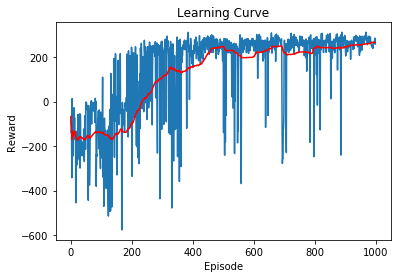

In [12]:
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(rewards)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(aver_reward, 'r') 

In [13]:
import pickle
with open("dddqn-rewards", "wb") as fp:
    pickle.dump(rewards, fp)
    
with open("dddqn-avg-rewards", "wb") as fp:
    pickle.dump(aver_reward, fp)   